# AutoInland Vehicle Insurance Claim Challenge

In [1]:
# Importing libraries

import pandas as pd
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_rows', None) # show all rows
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

## Visualization
from sklearn.metrics import plot_confusion_matrix
import missingno as msno

## ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.model_selection import cross_val_score

In [2]:
# Load files into a pandas dataframe
## We'll set the ID column as the index, since it is a unique identifier

train = pd.read_csv('https://raw.githubusercontent.com/lucamarcelo/AutoInland-Vehicle-Insurance-Claim-Challenge/main/Train.csv', index_col='ID')
test = pd.read_csv('https://raw.githubusercontent.com/lucamarcelo/AutoInland-Vehicle-Insurance-Claim-Challenge/main/Test.csv', index_col='ID')
submission_format = pd.read_csv('https://raw.githubusercontent.com/lucamarcelo/AutoInland-Vehicle-Insurance-Claim-Challenge/main/SampleSubmission.csv')
variable_names = pd.read_csv('https://raw.githubusercontent.com/lucamarcelo/AutoInland-Vehicle-Insurance-Claim-Challenge/main/VariableDefinitions.csv')


## Workflow 
1) **EDA - What data are we dealing with?**
    - Display distributions of numerical and categorical variables
    - Are there any inconsistencies? 
    - Are the variables encoded correctly? 
2) **Preprocessing - Let's clean our data**
    - Missing Values 
    - Outliers
    - Categorical Values (unique values, encoding)
3) **Feature Engineering and Selection - What can be improved?**
    - Look at correlation with target varible
    - Multicollineality
4) **Training time - Model building and comparison**
    - Compare different algos 
    - Use gridsearch/randomsearch for parameter tuning
5) **Create Submission - Predictions on test data**

## 1. EDA - What data are we dealing with?
### 1.1 General understanding of the data we have

In [3]:
# What are the variables we're dealing with? 

variable_names

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [4]:
# Check dimensionality of the data 

print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 13)
The shape of the test set is: (1202, 12)


In [5]:
# Visualize data 

train.head()

,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
ID,,,,,,,,,,,,,
ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [6]:
# How are the features encoded? 

train.dtypes

Policy Start Date         object
Policy End Date           object
Gender                    object
Age                        int64
First Transaction Date    object
No_Pol                     int64
Car_Category              object
Subject_Car_Colour        object
Subject_Car_Make          object
LGA_Name                  object
State                     object
ProductName               object
target                     int64
dtype: object

### 1.2 Numerical features

In [7]:
# Check numerical variables

train.describe()

,Age,No_Pol,target
count,12079.000000,12079.000000,12079.000000
mean,42.234539,1.307227,0.120457
std,97.492565,0.733085,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


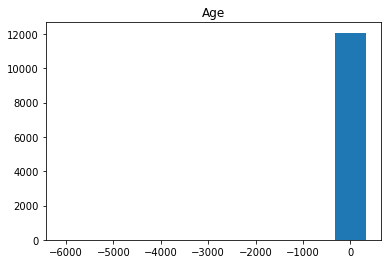

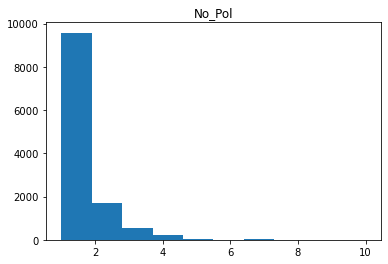

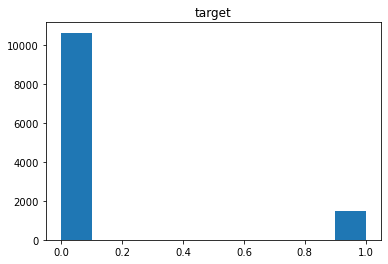

In [8]:
# Distributions of numerical data - histograms

for col in train[['Age', 'No_Pol', 'target']].columns: 
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### 1.3 Categorical features

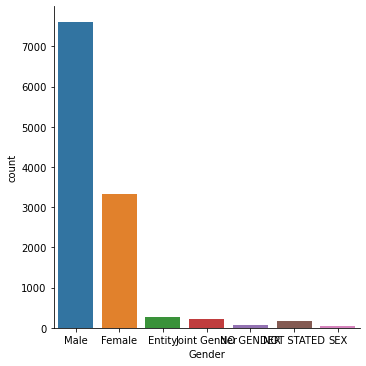

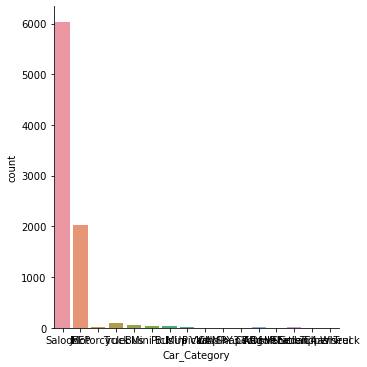

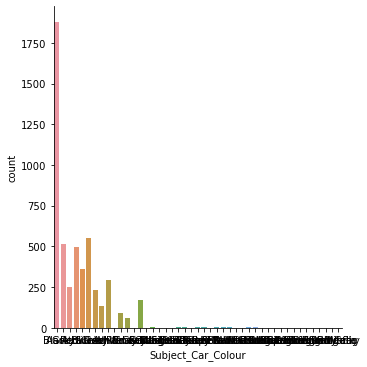

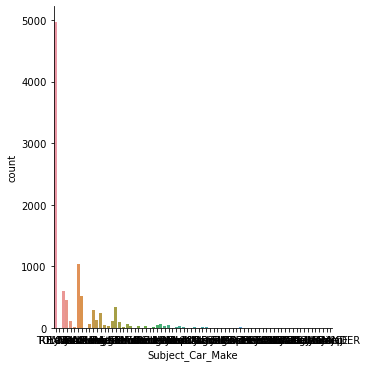

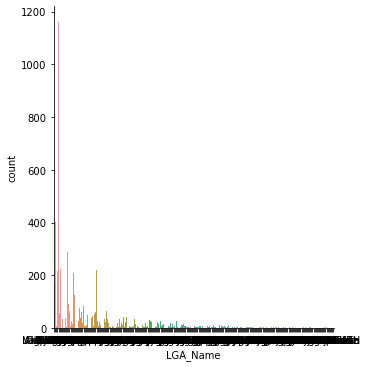

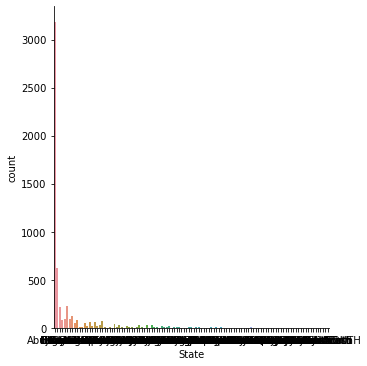

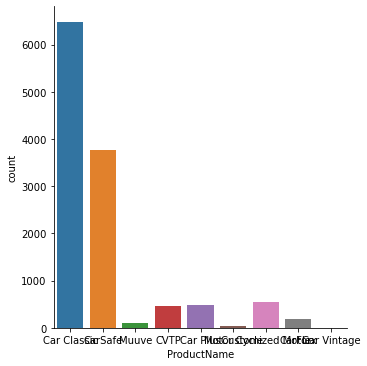

In [9]:
# Distribution of categorical data - barcharts 

categorical_variables = train.select_dtypes(exclude=[np.number, np.datetime64])
categorical_variables.drop(columns=['Policy Start Date', 'Policy End Date', 'First Transaction Date'], axis=1, inplace=True)

categorical_variables.head()

for col in categorical_variables:
    sns.catplot(x=col, kind="count", data=categorical_variables)

In [10]:
# Unique values per categorical variable

def unique_per_col(df): 
    #Selecting only categorical cols
    cols = (df.dtypes == 'object')
    object_cols = list(cols[cols].index)
    #Count unique values
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    d = dict(zip(object_cols, object_nunique))
    #Print number of unique entries by column, in ascending order
    for row in sorted(d.items(), key=lambda x: x[1]):
        print(row)
    

# We will leave the date variables out, since they have too many different values and will be encoded differently later on
unique_per_col(train.drop(['Policy Start Date', 'Policy End Date', 'First Transaction Date'], axis=1))

('Gender', 7)
('ProductName', 9)
('Car_Category', 16)
('Subject_Car_Colour', 45)
('Subject_Car_Make', 74)
('State', 111)
('LGA_Name', 258)


### 1.4 Some exploring of the target variable
Let's see how our target variable distributes across a variety of predictors.

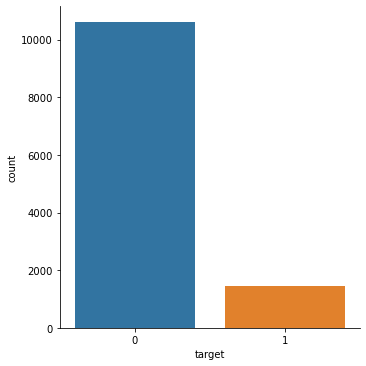

In [11]:
# Distribution of target variable

sns.catplot(x=train['target'], kind="count", data=train)

<AxesSubplot:xlabel='Gender'>

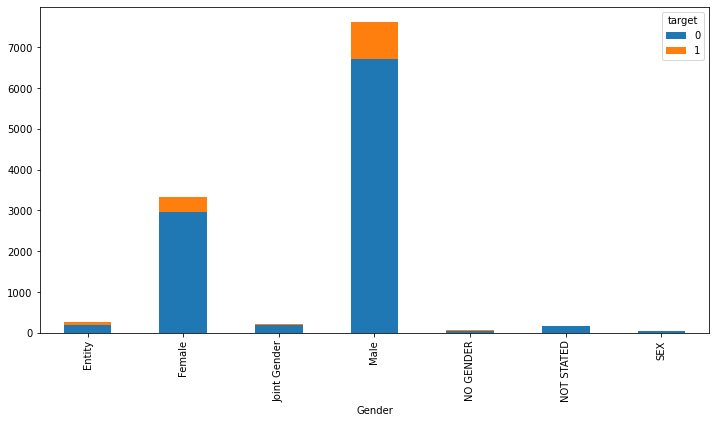

In [12]:
# Gender vs target

pd.crosstab(train['Gender'], train['target']).plot.bar(stacked=True, figsize=(12,6))

<AxesSubplot:xlabel='ProductName'>

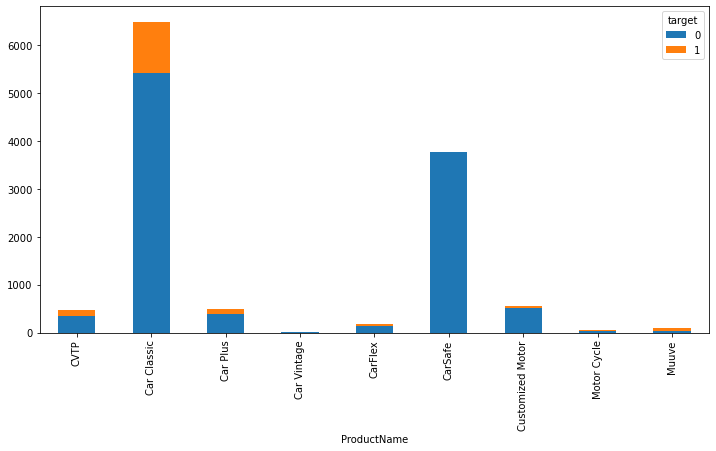

In [13]:
# ProductName (insurance type) vs target

pd.crosstab(train['ProductName'], train['target']).plot.bar(stacked=True, figsize=(12,6))

<AxesSubplot:xlabel='Car_Category'>

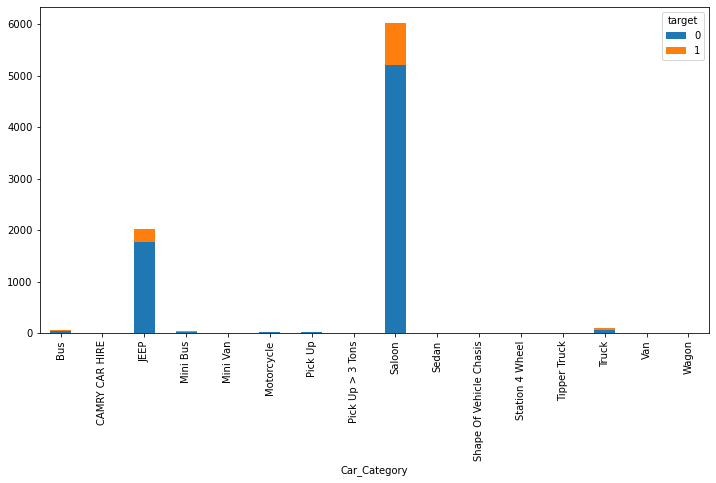

In [14]:
# Car category vs target

pd.crosstab(train['Car_Category'], train['target']).plot.bar(stacked=True, figsize=(12,6))

<AxesSubplot:xlabel='Subject_Car_Colour'>

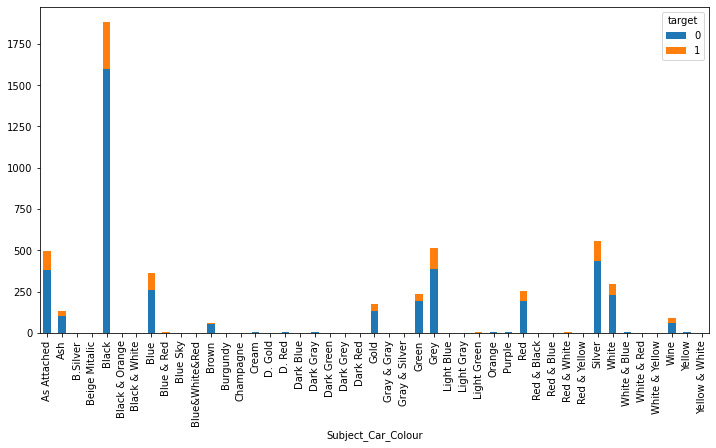

In [15]:
# Car color vs target

pd.crosstab(train['Subject_Car_Colour'], train['target']).plot.bar(stacked=True, figsize=(12,6))

### Conlusions from EDA
Now that we have a better understanding of the data at hand and how it's distributed, we can make some conclusions: 
- Looking at the head of the train dataframe, we can already see, that there seems to be a lot of **missing values**, which we will deal with in the following part
- Furthermore there seems to be some **faulty values**, e.g. in the age column there are some negative values and some very high values, that don't make sense. The same applies to some categorical variables, like gender. Those values will be converted to NAs
- The three date variables are not encoded correctly, i.e. they're not encoded as date, but as string. We will correct this issue. 
- In most categorical variables there's one label that makes up the (large) majority of the data. Binning the other labels might be a solution to reducing the cardinality of those variables. 
- Inspecting the target variable we can see that we're working with a very inbalanced dataset. We will need to take this into account when creating our model, so that it won't be biased. 
    - We also see that the proportion of those claiming insurance is higher for black car owners, which makes sense, as they are more difficult to see
    - The same applies to Saloon car owners
    - Those with the "CarSafe" insurance seem to never claim insurance
 

## 2. Preprocessing - Let's clean our data
To be able to feed the data we have into a machine learning model, we have to:

- check for faulty values (for example in our age column)
- impute missing values
- correct inconsistencies like wrongly declared datatypes (our date variables)
- regroup/bin labels with low representation from categorical variables

As far as the encoding goes, we will do it right before fitting the data to our model, since this allows to do some feature engineering beforehand.

In [16]:
# We'll combine the train and test data for easier preprocessing

all_data = pd.concat((train, test))
print('All data: ',all_data.shape )

All data:  (13281, 13)


In [17]:
all_data.shape

(13281, 13)

### 2.1 Checking for faulty values

In [18]:
# Age 
## Replace unresonable values, i.e. replacing those values that are outside the range of 18-100 with NA 

all_data['Age'] = all_data['Age'].where((18 <= all_data['Age']) & (all_data['Age'] <= 100))


# No_pol 
## Replace values above 4 with NA

all_data['No_Pol'] = all_data['No_Pol'].where((all_data['No_Pol'] <= 4))

### 2.2 Missing values

,variable,Unique values,Nan %,zeros %
7,Subject_Car_Colour,47,57.7,0.0
10,State,114,53.8,0.0
9,LGA_Name,271,53.7,0.0
6,Car_Category,17,30.9,0.0
8,Subject_Car_Make,76,20.5,0.0
12,target,3,9.1,80.0
3,Age,76,7.7,0.0
2,Gender,8,3.0,0.0
5,No_Pol,5,0.5,0.0
0,Policy Start Date,376,0.0,0.0


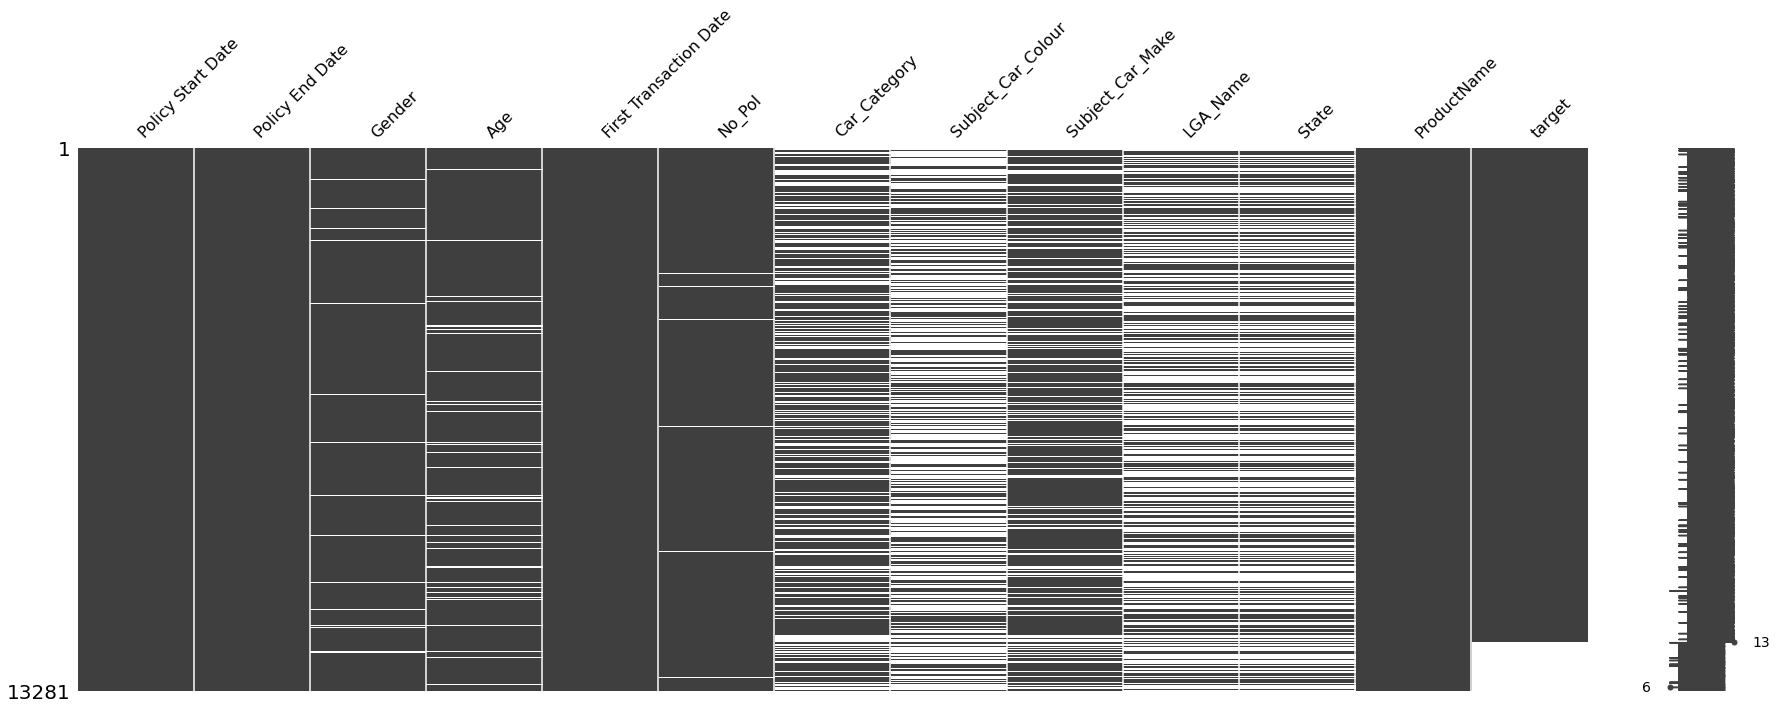

In [19]:
# Check where there's missing values

# Plot missing values for the whole dataset 

msno.matrix(all_data, figsize = (30,10))

def missing_values(data):
    df = pd.DataFrame()
    for col in list(data):
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
        zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)
        #empty = round((data[data[col]] == '').sum()/data.shape[0]*100, 1)
        df = df.append(pd.DataFrame([col,
                                     len(unique_values),
                                     nans,
                                     zeros,
                                     #empty
                                    ]).T, ignore_index = True)

    return df.rename(columns = {0: 'variable',
                                1: 'Unique values',
                                2: 'Nan %',
                                3: 'zeros %',
                                #4: 'empty'
                               }).sort_values('Nan %', ascending=False)

missing_values(all_data)

#### Imputation of missing values
Keep in mind that we have missing values in `Target`, because we don't know the answer for the labels in the test data! 

In [20]:
# Impute missing values

# Create a COPY of dataframe
all_data_imp = all_data.copy()


## Use a CONSTANT ('Unknown')
### Car color 
all_data_imp['Subject_Car_Colour'].fillna('Unknown', inplace=True)

### State
all_data_imp['State'].fillna('Unknown', inplace=True)

### LGA_Name
all_data_imp['LGA_Name'].fillna('Unknown', inplace=True)


## Use most common class, aka MODE
### Car_Category
all_data_imp['Car_Category'].fillna(all_data_imp['Car_Category'].mode()[0], inplace=True)

### Subject_Car_Make
all_data_imp['Subject_Car_Make'].fillna(all_data_imp['Subject_Car_Make'].mode()[0], inplace=True)

### Gender
all_data_imp['Gender'].fillna(all_data_imp['Gender'].mode()[0], inplace=True)

### Gender
all_data_imp['No_Pol'].fillna(all_data_imp['No_Pol'].mode()[0], inplace=True)


## Use median  
### Age
all_data_imp['Age'].fillna(all_data_imp['Age'].median(), inplace=True)

### 2.3 Wrongly declared datatype

In [21]:
# Let's take a view again on our datatypes
## Looks like everything makes sense, except the date variables that are encoded as strings, and the numerical variables that should be integers

all_data_imp.dtypes

Policy Start Date          object
Policy End Date            object
Gender                     object
Age                       float64
First Transaction Date     object
No_Pol                    float64
Car_Category               object
Subject_Car_Colour         object
Subject_Car_Make           object
LGA_Name                   object
State                      object
ProductName                object
target                    float64
dtype: object

In [22]:
# Convert string date variables into date format

for col in all_data_imp[['Policy Start Date', 'Policy End Date', 'First Transaction Date']]:
    all_data_imp[col] = pd.to_datetime(all_data_imp[col], format='%Y-%m-%d')    

In [23]:
# We can also see that some of the values that should be integers, like age and the target are encoded as floating point values
# This isn't a huge issues, but we will also correct this

all_data_imp[['Age', 'No_Pol']] = all_data_imp[['Age', 'No_Pol']].astype(int)

In [24]:
# Check the datatypes again -- we can now see that the date and integer issue has been resolved.
# Time to move on to the next step 

all_data_imp.dtypes

Policy Start Date         datetime64[ns]
Policy End Date           datetime64[ns]
Gender                            object
Age                                int64
First Transaction Date    datetime64[ns]
No_Pol                             int64
Car_Category                      object
Subject_Car_Colour                object
Subject_Car_Make                  object
LGA_Name                          object
State                             object
ProductName                       object
target                           float64
dtype: object

### 2.4 Reducing cardinality of categorical variables
As we've seen before some of the categorical variable have high cardinality, i.e. they have a lot of different labels/levels/categories.
This represents a problem for us when we need to encode them in the following step - especially if we want to use one-hot encoding, since many labels would result in many new features. 

In [25]:
# Depending on each variable, we will group values with low proportion together

for col in all_data_imp.select_dtypes(exclude=[np.number, np.datetime64]):
    print(all_data_imp.select_dtypes(exclude=[np.number, np.datetime64])[col].value_counts(normalize=True))

Male            0.659288
Female          0.277012
Entity          0.022589
Joint Gender    0.017920
NOT STATED      0.014306
NO GENDER       0.005722
SEX             0.003162
Name: Gender, dtype: float64
Saloon                     0.808900
JEEP                       0.167382
Truck                      0.008132
Bus                        0.004217
Mini Bus                   0.003388
Pick Up                    0.002409
Motorcycle                 0.001355
Sedan                      0.001054
Mini Van                   0.000979
Wagon                      0.000753
Station 4 Wheel            0.000452
Shape Of Vehicle Chasis    0.000452
Van                        0.000226
Pick Up > 3 Tons           0.000151
CAMRY CAR HIRE             0.000075
Tipper Truck               0.000075
Name: Car_Category, dtype: float64
Unknown           0.576689
Black             0.154883
Silver            0.045554
Grey              0.042542
As Attached       0.041789
Blue              0.029968
White             0.024

#### Combining levels of categorical variables

In [26]:
# Gender

## Keep first  labels and collapse the rest
categories_to_keep = all_data_imp['Gender'].value_counts().index[:2] 

# replace remaining labels with 'Other'
all_data_imp.loc[(~all_data_imp['Gender'].isin(categories_to_keep)), 'Gender'] = 'Other'

In [27]:
# Car_Category

## Keep first three labels and collapse the rest
categories_to_keep = all_data_imp['Car_Category'].value_counts().index[:2] 

# replace remaining labels with 'Other'
all_data_imp.loc[(~all_data_imp['Car_Category'].isin(categories_to_keep)), 'Car_Category'] = 'Other'

In [28]:
# Subject_Car_Colour

## Replace 'As Attached' with 'Unknown', since we don't know what the color is
all_data_imp['Subject_Car_Colour'][all_data_imp['Subject_Car_Colour'] == 'As Attached'] = 'Unknown'

## Keep first seven labels and collapse the rest
categories_to_keep = all_data_imp['Subject_Car_Colour'].value_counts().index[:7] 

# replace remaining labels with 'Other'
all_data_imp.loc[(~all_data_imp['Subject_Car_Colour'].isin(categories_to_keep)), 'Subject_Car_Colour'] = 'Other'

In [29]:
# Subject_Car_Make
## Before Grouping the different labels, for this one we will create a new variable, to keep the original one
## we will use the original one for feature engineering later on 

## Create copy of original column 
all_data_imp['Subject_Car_Make_grouped'] = all_data_imp['Subject_Car_Make']

## Keep first three labels and collapse the rest
categories_to_keep = all_data_imp['Subject_Car_Make_grouped'].value_counts().index[:7] 

# replace remaining labels with 'Other'
all_data_imp.loc[(~all_data_imp['Subject_Car_Make_grouped'].isin(categories_to_keep)), 'Subject_Car_Make_grouped'] = 'Other'

In [30]:
# LGA_Name

## Keep first four labels and collapse the rest
categories_to_keep = all_data_imp['LGA_Name'].value_counts().index[:3] 

# replace remaining labels with 'Other'
all_data_imp.loc[(~all_data_imp['LGA_Name'].isin(categories_to_keep)), 'LGA_Name'] = 'Other'

In [31]:
# State

## Keep first four labels and collapse the rest
categories_to_keep = all_data_imp['State'].value_counts().index[:3] 

# replace remaining labels with 'Other'
all_data_imp.loc[(~all_data_imp['State'].isin(categories_to_keep)), 'State'] = 'Other'

In [32]:
# For now we will keep all the categories in the ProductName variable,
# because it might be important for interpretability and also because it doesn't have that many levels 

all_data_imp['ProductName'].value_counts(normalize=True)

Car Classic         0.537761
CarSafe             0.312778
Customized Motor    0.045554
Car Plus            0.039380
CVTP                0.038325
CarFlex             0.014607
Muuve               0.007530
Motor Cycle         0.003689
Car Vintage         0.000376
Name: ProductName, dtype: float64

## 3 Feature Engineering and Selection
Looking at the data below, these are some following variables we could create: 
- Policy Length (difference between the policy date variable)
- Extracting Month and year (and day) for date variables
- Grouping the `Age` variable 
- Eliminating 'First Transaction Date', because it seems to contain the same info as `Policy Start Date`
- Group `Subject_Car_Make` according to producing country or rather region (e.g. American, Asian, European) 
    - for this some domain knowledge or research might be required 
-    
 

## 3.1 Feature Engineering
#### `Policy Duration` - Difference between the Policy start and end date 
My intuition tells me that people with a longer duration are more likely to claim the insurance. 
<br> Let's see later on if that's true. 

In [33]:
# Policy Duration

all_data_imp['Policy_Duration'] = all_data_imp['Policy End Date'] - all_data_imp['Policy Start Date']
all_data_imp['Policy_Duration'] = round(all_data_imp['Policy_Duration'] / np.timedelta64(1, 'D'),
                                        2).astype(int)

#### Dropping `First Transaction Date`
The column contains exactly the same informatino as `Policy Start Date`.<br>
Therefore we can drop it.

In [34]:
# Drop First Transaction Date

## Check if both columns are the same
all_data_imp['Policy Start Date'].equals(all_data_imp['First Transaction Date']) # they're identical 

## Drop the column
all_data_imp.drop('First Transaction Date', axis=1, inplace=True)

#### Extract year, month, and day from the date columns
This will allow us to work with these values much better.

In [35]:
# Extract for Policy Start Date

all_data_imp['Policy_Start_Year'] = all_data_imp['Policy Start Date'].dt.year
all_data_imp['Policy_Start_Month'] = all_data_imp['Policy Start Date'].dt.month
all_data_imp['Policy_Start_Day'] = all_data_imp['Policy Start Date'].dt.day

In [36]:
# Extract for Policy End Date

all_data_imp['Policy_End_Year'] = all_data_imp['Policy End Date'].dt.year
all_data_imp['Policy_End_Month'] = all_data_imp['Policy End Date'].dt.month
all_data_imp['Policy_End_Day'] = all_data_imp['Policy End Date'].dt.day

#### Grouping `Age`
Instead of having the Age column as it is, let's group them together, since maybe younger and older drivers might have more accidents.
<br> But that is just an intuition. Grouping the age like this doesn't necessarily tell us much about how experienced a driver is.
<br> Even though younger drivers (close to 18) probably are less experienced and might crash their car more often. 

In [37]:
# Grouping Age

all_data_imp['Age_Group'] = pd.cut(all_data_imp['Age'], bins=[18,24,64,100],labels=['Youth','Adult','Elderly'])

#### Grouping `Subject_Car_Make` 
We will group this feature according to where the Car Brand comes from. <br>
I.e. whether it is an American, Asian or European brand.

After that we will also drope the original `Subject_Car_Make`, since it originally had too many values

In [38]:
## create a list of our conditions
conditions = [
    (all_data_imp['Subject_Car_Make'].isin(['TOYOTA', 'Honda', 'Lexus', 'Hyundai', 'Kia', 'Nissan', 'Mitsubishi', 'ACURA', 'Mazda', 'Infiniti', 'Isuzu', 'Suzuki', 'GAC', 'Subaru', 'FOTON', 'Geely', 'Ashok Leyland', 'CHANGAN', 'Yamaha', 'Howo', 'Tata', 'REXTON', 'Raston', 'Bajaj', 'Jincheng', 'BRILLIANCE', 'ZOYTE'])),
    (all_data_imp['Subject_Car_Make'].isin(['Mercedes', 'Volkswagen', 'Iveco', 'Range Rover', 'BMW', 'Land Rover', 'Land Rover.', 'Man', 'Peugeot', 'Volvo', 'Audi', 'DAF', 'Skoda', 'Porsche', 'Scania', 'Opel', 'Renault', 'Jaguar', 'MINI COOPER', 'Astra', 'Seat', 'Fiat'])),
    (all_data_imp['Subject_Car_Make'].isin(['Mack', 'Pontiac', 'Chevrolet', 'Jeep', 'Dodge', 'GMC', 'LIBERTY', 'Wrangler Jeep', 'Ford',  'Grand Cherokee', 'Chrysler', 'Hummer', 'Rols Royce', 'COMMANDER', 'MG', 'Caddillac', 'Lincoln', 'Buik'])),
    (all_data_imp['Subject_Car_Make'].isin(['.', 'As Attached', 'Innson', 'Black', 'ABG', 'Ashok Leyland', 'KA', 'Motorcycle']))
    ]

## create a list of the values we want to assign for each condition
values = ['Asian', 'European', 'American', 'Other']

## create a new column and use np.select to assign values to it using our lists as arguments
all_data_imp['Car_Brand'] = np.select(conditions, values)

## display updated DataFrame
all_data_imp.head()

,Policy Start Date,Policy End Date,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Subject_Car_Make_grouped,Policy_Duration,Policy_Start_Year,Policy_Start_Month,Policy_Start_Day,Policy_End_Year,Policy_End_Month,Policy_End_Day,Age_Group,Car_Brand
ID,,,,,,,,,,,,,,,,,,,,,,
ID_0040R73,2010-05-14,2011-05-13,Male,30,1,Saloon,Black,TOYOTA,Unknown,Unknown,Car Classic,0.0,TOYOTA,364,2010,5,14,2011,5,13,Adult,Asian
ID_0046BNK,2010-11-29,2011-11-28,Female,79,1,JEEP,Grey,TOYOTA,Unknown,Unknown,Car Classic,1.0,TOYOTA,364,2010,11,29,2011,11,28,Elderly,Asian
ID_005QMC3,2010-03-21,2011-03-20,Male,43,1,Saloon,Red,TOYOTA,Unknown,Unknown,Car Classic,0.0,TOYOTA,364,2010,3,21,2011,3,20,Adult,Asian
ID_0079OHW,2010-08-21,2011-08-20,Male,41,1,Saloon,Unknown,TOYOTA,Unknown,Unknown,CarSafe,0.0,TOYOTA,364,2010,8,21,2011,8,20,Adult,Asian
ID_00BRP63,2010-08-29,2010-12-31,Other,20,3,Saloon,Unknown,TOYOTA,Other,Lagos,Muuve,1.0,TOYOTA,124,2010,8,29,2010,12,31,Youth,Asian


### 3.2 Feature selection
Now that we've created some new variables, we can right away drop a few features that we'll probably not need anymore. <br>
Those are: 
- `Policy Start Date`
- `Policy End Date` 
- `Subject_Car_Make`

Then we will look at some other factors that might be indicative if we should keep or drop other features. 

In [39]:
# Drop above mentioned features

all_data_imp.drop(columns=['Policy Start Date', 'Policy End Date', 'Subject_Car_Make'], axis=1, inplace=True)

In [40]:
# And reorder the columns - this is just personal preference, we could have left the columns as they are, too

all_data_imp = all_data_imp[['Policy_Start_Year',
                 'Policy_Start_Month', 
                 'Policy_Start_Day',
                 'Policy_End_Year',
                 'Policy_End_Month',
                 'Policy_End_Day',
                 'Policy_Duration',
                 'Gender',
                 'Age',
                 'Age_Group',
                 'No_Pol',
                 'ProductName',
                 'LGA_Name',
                 'State',
                 'Subject_Car_Make_grouped',
                 'Car_Brand',
                 'Car_Category',
                 'Subject_Car_Colour',
                 'target']]

# And change some feature names - again this is personal preference, but will give a more uniform look and feel to the features

all_data_imp.rename(columns={'ProductName': 'Product_Name', 
                             'Subject_Car_Make_grouped': 'Car_Manufacturer',
                             'Car_Brand': 'Car_Manufacturer_Region',
                             'Subject_Car_Colour': 'Car_Colour',
                             'target': 'Target'}, 
                   inplace=True)

#### BEFORE: Encoding of categorical variables

Before we can proceed and look at the correlations for example, we will have to encode the categorical variables first. 
Since we don't have a lot of categorical variables, we will do it "manually", which will allow us to look at each variable 
and decide which type of encoding would make most sense. 



In [41]:
# See what categorical variables we're dealing with

all_data_imp.select_dtypes(exclude=np.number)[:5]

,Gender,Age_Group,Product_Name,LGA_Name,State,Car_Manufacturer,Car_Manufacturer_Region,Car_Category,Car_Colour
ID,,,,,,,,,
ID_0040R73,Male,Adult,Car Classic,Unknown,Unknown,TOYOTA,Asian,Saloon,Black
ID_0046BNK,Female,Elderly,Car Classic,Unknown,Unknown,TOYOTA,Asian,JEEP,Grey
ID_005QMC3,Male,Adult,Car Classic,Unknown,Unknown,TOYOTA,Asian,Saloon,Red
ID_0079OHW,Male,Adult,CarSafe,Unknown,Unknown,TOYOTA,Asian,Saloon,Unknown
ID_00BRP63,Other,Youth,Muuve,Other,Lagos,TOYOTA,Asian,Saloon,Unknown


In [42]:
all_data_imp['Gender'].value_counts(normalize=True)

Male      0.659288
Female    0.277012
Other     0.063700
Name: Gender, dtype: float64

In [43]:
# Label Encoding for given variables

## Gender -- Binary Encoding 
all_data_imp['Gender'] = all_data_imp['Gender'].map( {'Male': 0, 'Female': 1, 'Other': 2} ).astype(int)

## Age_Group -- Label Encoding
### There seems to be a missing value in 'Age_Group', which we'll have to impute. We'll use the mode
all_data_imp['Age_Group'].fillna(all_data_imp['Age_Group'].mode()[0], inplace=True)
all_data_imp['Age_Group'] = all_data_imp['Age_Group'].map( {'Youth': 1, 'Adult': 2, 'Elderly': 3} ).astype(int)

## Product_Name -- Label Encoding
all_data_imp['Product_Name'] = all_data_imp['Product_Name'].map( {'Car Classic': 1, 'CarSafe': 2, 'Customized Motor': 3, 'Car Plus': 4, 'CVTP': 5, 'CarFlex': 6, 'Muuve': 7, 'Motor Cycle': 8, 'Car Vintage': 9} ).astype(int)

In [44]:
# One-Hot Encoding LGA_Name

## use pd.concat to join the new columns with your original dataframe
all_data_imp = pd.concat([all_data_imp,pd.get_dummies(all_data_imp['LGA_Name'], prefix='LGA_')],axis=1)

## now drop the original column (you don't need it anymore)
all_data_imp.drop(['LGA_Name'],axis=1, inplace=True)

In [45]:
# Let's do the rest for the remaining columns, too, by looping through them

for col in all_data_imp[['State', 'Car_Manufacturer', 'Car_Manufacturer_Region', 'Car_Category', 'Car_Colour']]:
    all_data_imp = pd.concat([all_data_imp,pd.get_dummies(all_data_imp[col], prefix=col, prefix_sep='_')],axis=1)
    all_data_imp.drop([col],axis=1, inplace=True)

#### Looking at correlation with the target variable

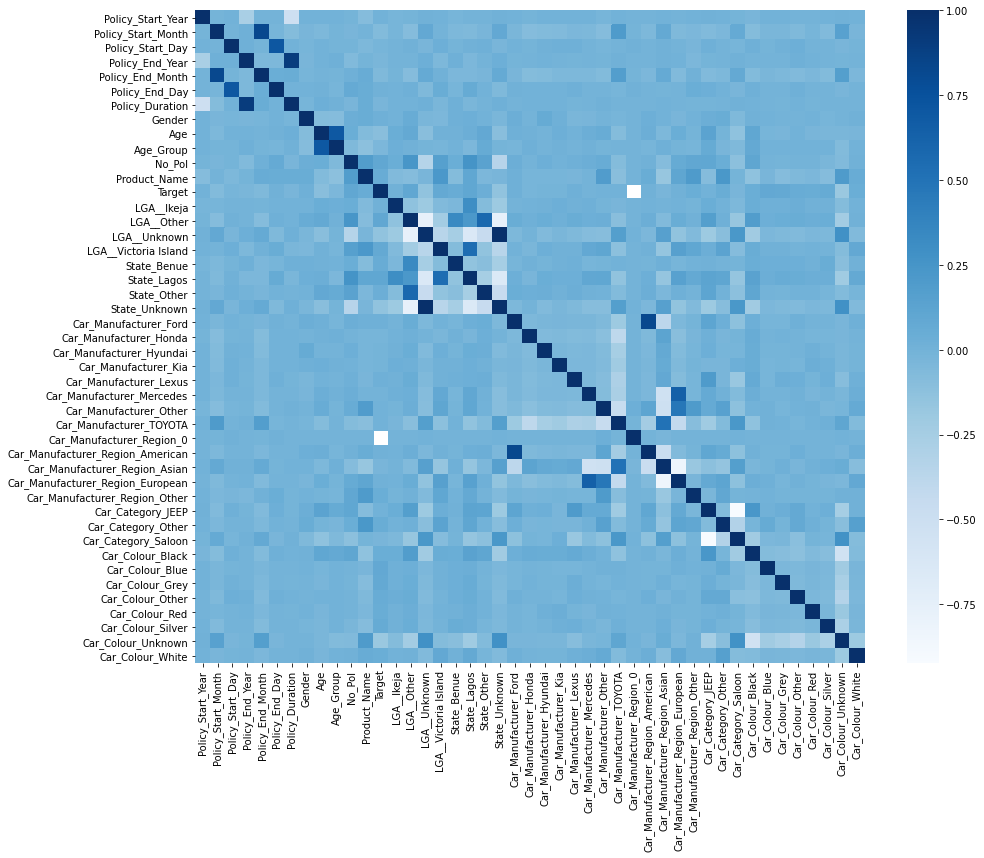

In [46]:
# Heatmap with correlations
plt.figure(figsize=(15,12))
correlations = all_data_imp.corr()
sns.heatmap(correlations, annot=False, cmap='Blues')
plt.show()

<AxesSubplot:>

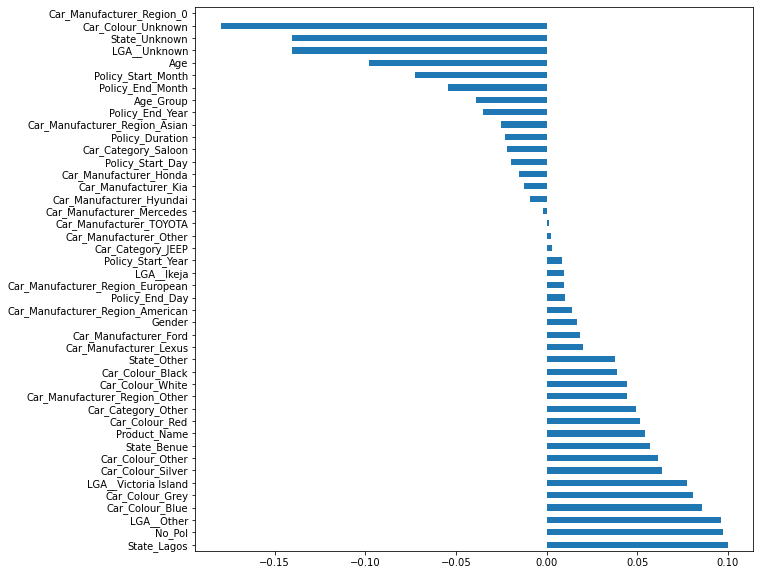

In [47]:
# Barchart with correlations

plt.figure(figsize=(10,10))
(correlations.Target
        .drop('Target') # don't compare the target variable with itself
        .sort_values(ascending=False)
        .plot
        .barh())

In [48]:
# Looking at the variance

print(all_data_imp.var())

Policy_Start_Year                       0.023704
Policy_Start_Month                     12.270345
Policy_Start_Day                       78.755493
Policy_End_Year                         0.243506
Policy_End_Month                       12.262694
Policy_End_Day                         80.342468
Policy_Duration                     42255.109028
Gender                                  0.368291
Age                                   128.878053
Age_Group                               0.087321
No_Pol                                  0.386069
Product_Name                            1.627559
Target                                  0.105956
LGA__Ikeja                              0.031894
LGA__Other                              0.222239
LGA__Unknown                            0.248649
LGA__Victoria Island                    0.087339
State_Benue                             0.049461
State_Lagos                             0.193885
State_Other                             0.125278
State_Unknown       

#### A few observations about the features: 
- None of the features have a particularly high correlation with the target variable
- Some features do however have a higher correlation than others with it
- For the time being we will work with ALL features and will make some adjustments later on to see if we can improve our models

Before the modeling we will also have a look at possible **Outliers**, since the variance in `Policy_Duration` seems a bit too large.

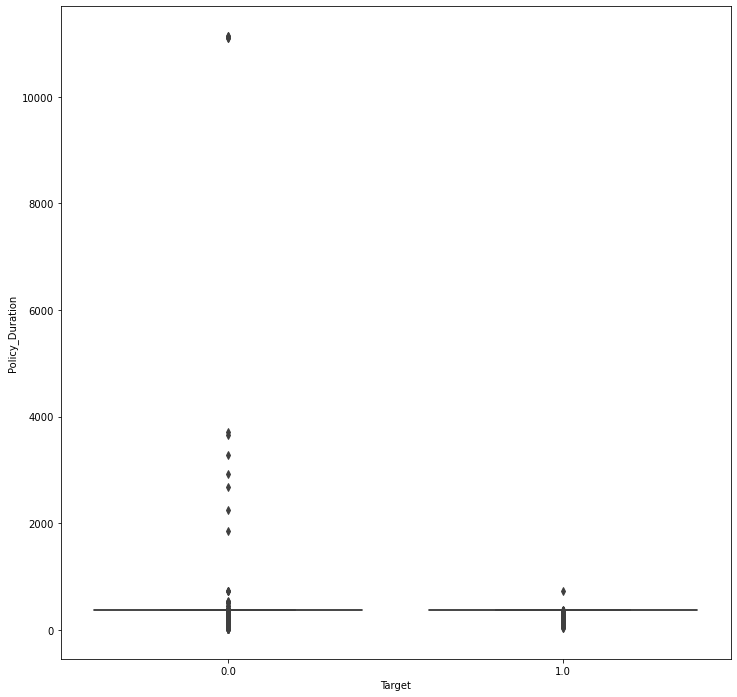

In [49]:
plt.figure(figsize=(12,12))
ax = sns.boxplot(x="Target", y="Policy_Duration", data=all_data_imp)

Someone with a policy duration of more than 10k days might not seem very realistic, but we'll have a closer look at those records:

In [50]:
condition = all_data_imp['Policy_Duration'] > 2000

all_data_imp[condition]

,Policy_Start_Year,Policy_Start_Month,Policy_Start_Day,Policy_End_Year,Policy_End_Month,Policy_End_Day,Policy_Duration,Gender,Age,Age_Group,No_Pol,Product_Name,Target,LGA__Ikeja,LGA__Other,LGA__Unknown,LGA__Victoria Island,State_Benue,State_Lagos,State_Other,State_Unknown,Car_Manufacturer_Ford,Car_Manufacturer_Honda,Car_Manufacturer_Hyundai,Car_Manufacturer_Kia,Car_Manufacturer_Lexus,Car_Manufacturer_Mercedes,Car_Manufacturer_Other,Car_Manufacturer_TOYOTA,Car_Manufacturer_Region_0,Car_Manufacturer_Region_American,Car_Manufacturer_Region_Asian,Car_Manufacturer_Region_European,Car_Manufacturer_Region_Other,Car_Category_JEEP,Car_Category_Other,Car_Category_Saloon,Car_Colour_Black,Car_Colour_Blue,Car_Colour_Grey,Car_Colour_Other,Car_Colour_Red,Car_Colour_Silver,Car_Colour_Unknown,Car_Colour_White
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_2484F7U,2010,10,19,2041,4,18,11139,0,36,2,1,6,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
ID_2SWIGKH,2007,3,4,2037,8,3,11110,0,37,2,1,2,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
ID_6BJMPUY,2009,2,26,2016,6,25,2676,0,37,2,1,1,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
ID_DC8ITK4,2006,7,6,2016,9,6,3715,0,39,2,3,9,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
ID_O51ZQ1B,2001,12,11,2011,12,10,3651,1,37,2,1,9,0.0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
ID_OEWBKGF,2005,8,5,2011,9,29,2246,1,44,2,1,5,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
ID_ULWS8VL,2003,4,13,2011,4,12,2921,0,41,2,2,9,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
ID_VJ1FAVO,2002,3,25,2011,3,24,3286,0,37,2,1,1,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
ID_XUX9C48,2010,10,19,2041,4,18,11139,0,36,2,1,6,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


- The individuals with an unusually high Policy_Duration seem to obviously also have to have a Policy end date much further in the future
- Maybe they have a long-term cover 
- All of the individuals with the longer term insurance are in the middle-aged class, which makes sense. We would expect to have such a long insurance for new drivers or older drivers 


We will keep the data as it is for now. 

## 4 Training time - Model building and comparison

- We'll train different classification algorithms and see which one works best 
- Then we will perform hyperparameter tuning with GridSearch or Randomsearch, depending on the number of parameters
- We will also try to train an artificial neural network (MLP) to see how well it does 

As far as the model evaluation we will use the F1-score, as per instructions on the website. 
The following information is given on the website itself:

**F1 Score:**<br>
A performance score that combines both precision and recall. It is a harmonic mean of these two variables.<br> Formula is given as: 2\*Precision\*Recall/(Precision + Recall)

**Precision:** <br>
This is an indicator of the number of items correctly identified as positive out of total items identified as positive.<br> Formula is given as: *TP/(TP+FP)*

**Recall / Sensitivity / True Positive Rate (TPR):** <br>
This is an indicator of the number of items correctly identified as positive out of total actual positives. Formula is given as: TP/(TP+FN)

Where:

TP=True Positive <br>
FP=False Positive <br>
TN=True Negative <br>
FN=False Negative <br>

### Train-Test Split

We'll first split the data in `all_data_imp` that we've preprocessed into `train_df` and `test_df`. This represents the origina train data (~90%) and test data (~10%), that will be used for assessing the score of our submission. 

In a second step, we'll also have to split the data in `train_df` again into train and test (sometimes also called the validation data).  

In [51]:
# Separate train and test data from the combined dataframe

ntrain = len(train)

train_df = all_data_imp[:ntrain]
test_df = all_data_imp[ntrain:]

# Check the shapes of the split dataset

train_df.shape, test_df.shape

((12079, 45), (1202, 45))

In [52]:
# Split train_df further 

X = train_df.drop('Target', axis=1)
y = train_df['Target']

#Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
                        X,
                        y,
                        test_size=0.2, 
                        random_state=42,
                        stratify = y)

### 4.1 kNN

Cross-validated F1-Score: 
0.19658289930354766

      
Accuracy:
TRAIN: 0.33207547169811324
TEST: 0.15656565656565655


<AxesSubplot:title={'center':'Confusion Matrix'}>

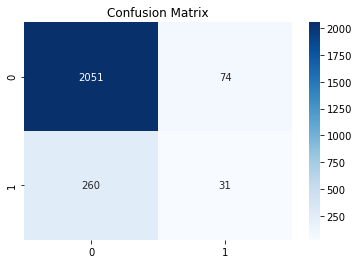

In [58]:
# Import relevant libraries/functions
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score as f1
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, precision_score, recall_score, roc_curve

#Scale Data 
normalized_X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
normalized_X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)

#Create model
knn = KNeighborsClassifier() 
knn.fit(normalized_X_train, y_train) 
y_knn_train = knn.predict(normalized_X_train) 
y_knn_test = knn.predict(normalized_X_test)

#CV Score
y_knn_cv = cross_val_score(knn, X, y, cv=5, scoring='f1')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated F1-Score: '); print("="*len("Cross-validated F1-Score:")); print(y_knn_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {f1(y_train, y_knn_train)}")
print(f"TEST: {f1(y_test, y_knn_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_knn_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

### 4.2 Random Forest

Cross-validated F1-Score: 
0.20062788337062232

      
Accuracy:
TRAIN: 0.8046511627906977
TEST: 0.20399113082039907


<AxesSubplot:title={'center':'Confusion Matrix'}>

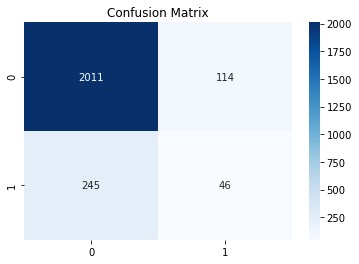

In [59]:
from sklearn.ensemble import RandomForestClassifier

#Create model
rf = RandomForestClassifier() 
rf.fit(X_train, y_train) 
y_rf_train = rf.predict(X_train) 
y_rf_test = rf.predict(X_test)

#CV Score
y_rf_cv = cross_val_score(rf, X, y, cv=5, scoring='f1')

##################
#Print results
##################
##CV Accuracy
print('Cross-validated F1-Score: '); print("="*len("Cross-validated F1-Score:")); print(y_rf_cv.mean())
print('''
      ''')
##Accuracy for train and test
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {f1(y_train, y_rf_train)}")
print(f"TEST: {f1(y_test, y_rf_test)}")
##Confusion Matrix
cm = confusion_matrix(y_test, y_rf_test)
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

### 4.3 Deep Neural Network

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [65]:
## Deep Neural Network

input_size = len(X.columns)

## INPUT
inputs = tf.keras.Input(shape=(input_size))

## HIDDEN LAYERS
### hidden layer 1
l_1 = layers.Dense(64, activation='relu')(inputs)
### hidden layer 2
l_2 = layers.Dense(64, activation='relu')(l_1)
### hidden layer 3
l_3 = layers.Dense(64, activation='relu')(l_2)

## OUTPUTS
outputs = layers.Dense(10, activation='sigmoid')(l_3)

## Model definition
neural_network = keras.Model(inputs=inputs, outputs=outputs)

In [66]:
# We have to define the f1 score manually
def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])

# fit the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)



neural_network.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

neural_network = model.fit(
    X,
    y,
    batch_size=64,
    epochs=50,
    shuffle=True, 
    validation_split=0.2
)



NameError: name 'model' is not defined

In [63]:
results = neural_network.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

,Policy_Start_Year,Policy_Start_Month,Policy_Start_Day,Policy_End_Year,Policy_End_Month,Policy_End_Day,Policy_Duration,Gender,Age,Age_Group,No_Pol,Product_Name,Target,LGA__Ikeja,LGA__Other,LGA__Unknown,LGA__Victoria Island,State_Benue,State_Lagos,State_Other,State_Unknown,Car_Manufacturer_Ford,Car_Manufacturer_Honda,Car_Manufacturer_Hyundai,Car_Manufacturer_Kia,Car_Manufacturer_Lexus,Car_Manufacturer_Mercedes,Car_Manufacturer_Other,Car_Manufacturer_TOYOTA,Car_Manufacturer_Region_0,Car_Manufacturer_Region_American,Car_Manufacturer_Region_Asian,Car_Manufacturer_Region_European,Car_Manufacturer_Region_Other,Car_Category_JEEP,Car_Category_Other,Car_Category_Saloon,Car_Colour_Black,Car_Colour_Blue,Car_Colour_Grey,Car_Colour_Other,Car_Colour_Red,Car_Colour_Silver,Car_Colour_Unknown,Car_Colour_White
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_0040R73,2010,5,14,2011,5,13,364,0,30,2,1,1,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0
ID_0046BNK,2010,11,29,2011,11,28,364,1,79,3,1,1,1.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
ID_005QMC3,2010,3,21,2011,3,20,364,0,43,2,1,1,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
ID_0079OHW,2010,8,21,2011,8,20,364,0,41,2,1,2,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
ID_00BRP63,2010,8,29,2010,12,31,124,2,20,1,3,7,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
